# Track MYI ice advected from Arctic

In [2]:
import numpy as np 
import cmocean
import cmocean.cm as cmo
import xarray as xr   
from pathlib import Path
from netCDF4 import Dataset
import glob
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import datetime 
from datetime import date 
import mpl_toolkits.basemap as bm
import matplotlib.animation as animation
import numpy.ma as ma
import matplotlib.cm as cm
from matplotlib.patches import Polygon
from scipy import signal, stats
import time
import cv2
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec
import warnings; warnings.simplefilter('ignore')
import pickle
import scipy

from functions import load_ice, trend, find_trends, plot_cartopy, decomp

In [3]:
# input data directory

path = Path('/extra-space1/data/tikoralukupload/cis-weekly/nc/')

# 2021
path2021 = Path('/extra-space1/data/tikoralukupload/cis-weekly/nc-for-May-2021-06-02')

# region of interest
region = 'HB'

# Projection for mapping
rot = ccrs.RotatedPole(pole_latitude=55,pole_longitude=150)

# Construct the full file name
fname = path / '{}.nc'.format(region)
fname2021 = path2021 / '{}.nc'.format(region) # 2021

### Load data into a `xarray.Dataset`:
# Note that the data is loaded lazily which means that no actual data are actually written
# into memory.
# ds = xr.open_dataset(fname, decode_times=False)
# ds2021 = xr.open_dataset(fname2021, decode_times=False)

ds = xr.open_dataset(fname)
ds2021 = xr.open_dataset(fname2021)

juld = ds.juld
juld2021 = ds2021.juld
# Combine data structures
juld = xr.concat([juld, juld2021], "juld")

# subset `xarray.Dataset` by index
# ds = ds.isel(x=slice(1700, None), y=slice(600, 1450))
# ds2021 = ds2021.isel(x=slice(1700, None), y=slice(600, 1450))

# Labrador shelf only
ds = ds.isel(x=slice(1800, 2500), y=slice(800, 1450))
ds2021 = ds2021.isel(x=slice(1800, 2500), y=slice(800, 1450))



# create shortcuts to the variables. 
lon = ds.longitude
lat = ds.latitude
land = ds.land
# E_FA = ds['E_FA']
E_CTold = ds['E_CT']
E_CT2021 = ds2021['E_CT']

E_SAold = ds['E_SA']
E_SA2021 = ds2021['E_SA']

E_CT = xr.concat([E_CTold, E_CT2021], dim="juld")
E_SA = xr.concat([E_SAold, E_SA2021], dim="juld")

In [4]:
years = juld.dt.year
months = juld.dt.month

years_unique = np.unique(years)
inds_clean = np.array([4,9,10,12,13,14,15,16,17,18,19,20,21,22,23,24])
years_unique_clean = years_unique[inds_clean]

Load Moore and Kwok datasets

In [7]:
# Ice Area Flux

flux_years = [1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2017,2018,2019]
area_flux = [32.72, 46.81, 15.68, 32.5, 35, 48.86, 44.31, 12.04, 26.81, 87.5, 77.27, 45.68, 92.27, 96.13, 70]

# Fill area flux array with nans where missing data
area_flux_filled = np.empty((len(MYI_area)))
area_flux_filled[:] = np.nan
area_flux_filled[1:13] = area_flux[:12]
area_flux_filled[20:23] = area_flux[12:]


From CIS:

Old ice: Sea ice which has survived at least one summer’s melt. Topographic features generally are smoother than first-year ice. It maybe subdivided into second-year ice and multiyear ice.

In [5]:
ds

<xarray.Dataset>
Dimensions:    (juld: 1043, x: 700, y: 650)
Coordinates:
  * x          (x) float64 1.834e+06 1.836e+06 1.836e+06 ... 2.532e+06 2.534e+06
  * y          (y) float64 2.96e+06 2.958e+06 2.958e+06 ... 2.312e+06 2.31e+06
  * juld       (juld) datetime64[ns] 1997-01-01 1997-02-01 ... 2020-10-26
Data variables:
    crs        int32 ...
    land       (y, x) float64 ...
    longitude  (y, x) float32 ...
    latitude   (y, x) float32 ...
    E_CA       (juld, y, x) float64 ...
    E_CB       (juld, y, x) float64 ...
    E_CC       (juld, y, x) float64 ...
    E_CD       (juld, y, x) float64 ...
    E_CT       (juld, y, x) float64 ...
    E_FA       (juld, y, x) float64 ...
    E_FB       (juld, y, x) float64 ...
    E_FC       (juld, y, x) float64 ...
    E_FD       (juld, y, x) float64 ...
    E_FE       (juld, y, x) float64 ...
    E_SA       (juld, y, x) float64 ...
    E_SB       (juld, y, x) float64 ...
    E_SC       (juld, y, x) float64 ...
    E_SD       (juld, y, x) float64 ...
    E_SE       (juld, y, x) float64 ...
    E_SO       (juld, y, x) float64 ...
    N_CB       (juld, y, x) float64 ...
    N_CFY      (juld, y, x) float64 ...
    N_CFY_M    (juld, y, x) float64 ...
    N_CFY_TK   (juld, y, x) float64 ...
    N_CFY_TN   (juld, y, x) float64 ...
    N_CG       (juld, y, x) float64 ...
    N_CGW      (juld, y, x) float64 ...
    N_CM       (juld, y, x) float64 ...
    N_CMY      (juld, y, x) float64 ...
    N_CN       (juld, y, x) float64 ...
    N_COI      (juld, y, x) float64 ...
    N_CSY      (juld, y, x) float64 ...
    N_CT       (juld, y, x) float64 ...
    N_CTK      (juld, y, x) float64 ...
    N_CTN      (juld, y, x) float64 ...
    N_CVTK     (juld, y, x) float64 ...
    N_CYI      (juld, y, x) float64 ...

In [8]:
# old ice is coded as E_SA==12. Flag as 1 and set other values to 0. MYI is coded as 14 but DNE in the array. 
# E_SA==11 is thick FYI
MYI = xr.where(E_SA==12,1,0)

# Count number of grid cells that have old ice each year
tic=time.time()
cnt=0
l = len(years_unique)
# Boolean array of MYI occurence
MYI_area = np.zeros(l)

# Use resample function to start years in Sept
cnt=0
MYI_yearly = MYI.resample(juld="AS-SEP")
for yr in list(MYI_yearly):
    MYI_area[cnt] = yr[1].sum()
    cnt+=1
    
toc = time.time()
print(toc-tic)   

# Remove data where area flux is missing for complete case analysis
MYI_area_sliced = np.concatenate((MYI_area[1:13], MYI_area[20:23]),axis=0)


# Trends for each time series
tr_MYI, b_MYI = np.polyfit(years_unique, MYI_area,1)
tr_flux, b_flux = np.polyfit(flux_years, area_flux,1)

# Calculate r value and p value
slope, intercept, r_value, p_value, std_err = stats.linregress(MYI_area_sliced,area_flux)

0.527747631072998


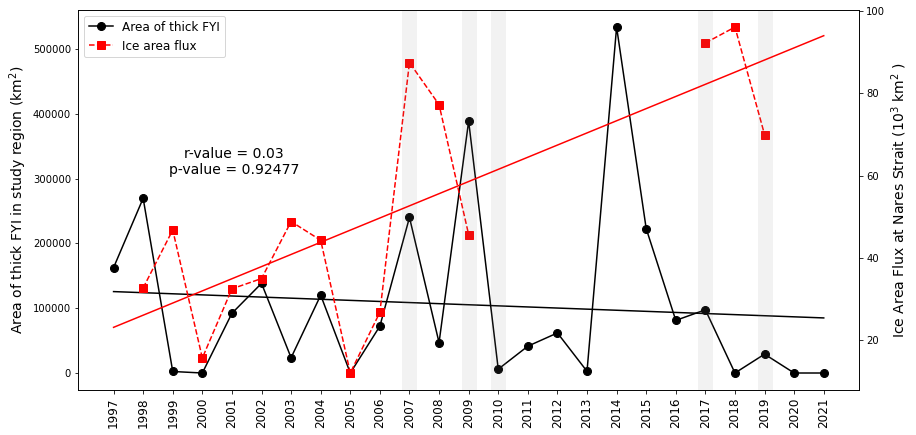

In [9]:
# plt.figure(figsize=(12,8), facecolor='white')
fig, ax1 = plt.subplots(figsize=(14,7), facecolor='white')
ax1.plot(years_unique,MYI_area,'ko-',markersize=8, label='Area of thick FYI')
# Plot trendline
ax1.plot(years_unique,years_unique*tr_MYI+b_MYI,'k')
plt.xticks(years_unique,rotation='vertical', fontsize=12)

ax1.set_ylabel(r'Area of thick FYI in study region (km$^2$)', fontsize=14)

ax2 = ax1.twinx()
ln3 = ax2.plot(years_unique, area_flux_filled,'rs--', markersize=8,label='Ice area flux')

ax2.set_ylabel(r'Ice Area Flux at Nares Strait ($10^3$ km$^2$ )', fontsize=14)

xcoords = [2007,2009,2010,2017]
for xc in xcoords:
    ax2.axvline(x=xc,color='grey',ls='-',linewidth=15, markersize=8,alpha=.1)

# Take out last plot from loop for legend purposes
ax2.axvline(x=2019,color='grey',ls='-',markersize=8,linewidth=15,alpha=.1)
ax2.plot(years_unique,years_unique*tr_flux+b_flux,'r')

# Colour tick labels where arch failed
# ax1.get_xticklabels()[10].set_color("red")x
# ax1.get_xticklabels()[12].set_color("red")
# ax1.get_xticklabels()[13].set_color("red")
# ax1.get_xticklabels()[20].set_color("red")
# ax1.get_xticklabels()[22].set_color("red")
# ax1.grid(b=True, which='major', color='grey', linestyle='-')

# Dsiplay r-value
ax2.text(0.2,0.6, 'r-value = %.2f\np-value = %.5f'%(r_value,p_value), fontsize=14,horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes,zorder=4)

fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes, fontsize=12)
# plt.title('Complete case analysis')
# plt.savefig('/home/mwang/CIS-project/figures/Jul17_area_flux_cca.png', dpi=200)

Four scenarios:
1) low R-square and low p-value (p-value <= 0.05)

2) low R-square and high p-value (p-value > 0.05)

3) high R-square and low p-value

4) high R-square and high p-value

Interpretation:
1) means that your model doesn't explain much of variation of the data but it is significant (better than not having a model)

2) means that your model doesn't explain much of variation of the data and it is not significant (worst scenario)

3) means your model explains a lot of variation within the data and is significant (best scenario)

4) means that your model explains a lot of variation within the data but is not significant (model is worthless)

# Detrend time series

detrending would tell you about how much just the inter-annual variability is correlated between the time series.

In [435]:
MYI_detrend = MYI_area - (years_unique*tr_MYI+b_MYI)
flux_detrend = area_flux - (np.array(flux_years)*tr_flux+b_flux)

# Calculate r value and p value for detrended tseries
MYI_detrend_sliced = np.concatenate((MYI_detrend[1:13], MYI_detrend[20:23]),axis=0)
slope, intercept, r_value_det, p_value_det, std_err = stats.linregress(MYI_detrend_sliced,flux_detrend)

Text(0.5, 1.0, 'Detrended time series')

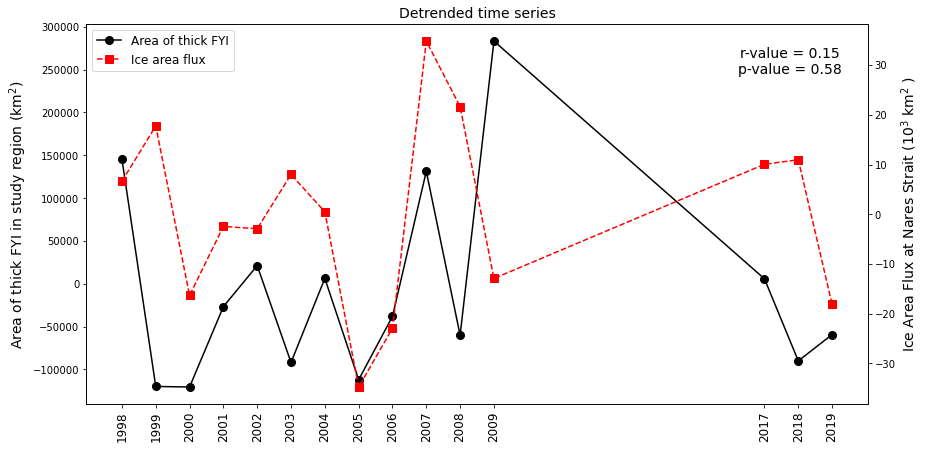

In [436]:
# plt.figure(figsize=(12,8), facecolor='white')
fig, ax1 = plt.subplots(figsize=(14,7), facecolor='white')
ax1.plot(flux_years,MYI_detrend_sliced,'ko-',markersize=8, label='Area of thick FYI')
# Plot trendline
plt.xticks(flux_years,rotation='vertical', fontsize=12)

ax1.set_ylabel(r'Area of thick FYI in study region (km$^2$)', fontsize=14)

ax2 = ax1.twinx()
ln3 = ax2.plot(flux_years, flux_detrend,'rs--', markersize=8,label='Ice area flux')

ax2.set_ylabel(r'Ice Area Flux at Nares Strait ($10^3$ km$^2$ )', fontsize=14)

xcoords = [2007,2009,2010,2017]
# for xc in xcoords:
#     ax2.axvline(x=xc,color='grey',ls='-',linewidth=15, markersize=8,alpha=.1)

# Take out last plot from loop for legend purposes
# ax2.axvline(x=2019,color='grey',ls='-',markersize=8,linewidth=15,alpha=.1)

# Display r and p value
ax2.text(0.9,0.9, 'r-value = %.2f\np-value = %.2f'%(r_value_det,p_value_det), fontsize=14,horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes,zorder=4)

fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes, fontsize=12)
plt.title('Detrended time series',fontsize=14)
# plt.savefig('/home/mwang/CIS-project/figures/Jul21_detrended_MYI_flux.png', dpi=200)